# Regression to Predict the runs scored given the type of bowlers expected to bowl and the state of the match

Here, we will consider all the data available as we trying to get a relation between the strike rate, and deliveries per wicket vs each type of bowler vs the expeted runs scored 

In [15]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../../Data/selected_data/processed_data.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217242 entries, 0 to 217241
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   batter               217242 non-null  object 
 1   bowler               217242 non-null  object 
 2   non_striker          217242 non-null  object 
 3   runs_by_bat          217242 non-null  int64  
 4   extra_runs           217242 non-null  int64  
 5   total_runs_delivery  217242 non-null  int64  
 6   current_team_total   217242 non-null  int64  
 7   runs_remain          217242 non-null  float64
 8   batter_runs          217242 non-null  int64  
 9   balls_faced          217242 non-null  int64  
 10  wickets_fallen       217242 non-null  int64  
 11  extra_type           217242 non-null  object 
 12  delivery             217242 non-null  float64
 13  over                 217242 non-null  int64  
 14  wicket_type          217242 non-null  object 
 15  player_out       

In [12]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2] ) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (data['innings'].isin(innings))
	]

	player_data.head()

	# 3 matches missing from the data
	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = [ 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen', 'bowling_team']
	player_scores= gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery', 'wickets_fallen']]
	first_ball['first_ball'] = (first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']

	# when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker'] == player_name].index
	
	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, ['batter_runs', 'balls_faced']] = [0, 0]
	
	
	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]	
	
	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)
	
	



	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)


	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 + matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis = 1)


	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]
		
		if player_data.empty:
			return player_data.drop('match_id', axis=1)
		
		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced
		
		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop('match_id', axis=1) # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby('match_id')['bowler_type'].value_counts().unstack(fill_value = 0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(remaining_ball_types, how='left', on='match_id')

	### Attaching the player_v_bowler results to this dataset
	player_vs_bowler = get_player_v_bowlers(player_name)
	


	bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
	for bowler_type in bowler_types:
			if bowler_type in player_vs_bowler.index:
				player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type, 'strike_rate'] / 100 *  player_scores[bowler_type]
				player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
			else:
				player_scores[bowler_type] = 0
				player_scores[f'{bowler_type} Expected Runs'] = 0
				player_scores[f'{bowler_type} Expected Wickets'] = 0
	
	# player_scores.fillna(0, inplace=True)
	return player_scores

def get_player_v_bowlers(player_name: str, innings = [1, 2]) -> pd.DataFrame:
	player_data = data.loc[
			(data['batter'] == player_name) & (data['innings'].isin(innings))
		]

	player_data.head()

	# Convert all medium bowlers to fast
	player_data.loc[player_data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
	player_data.loc[player_data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'


	player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out') 


	cols = ['batter', 'non_striker', 'runs_by_bat', 'out', 'won', 'innings', 'over', 'delivery','bowler_type']
	player_data = player_data[cols]

	gp = player_data.groupby('bowler_type')

	player_v_bowler = pd.DataFrame()
	player_v_bowler['strike_rate'] = round(gp['runs_by_bat'].mean() * 100, 3)
	player_v_bowler['strike_rate_std'] = gp['runs_by_bat'].std()
	player_v_bowler['wickets'] = gp['out'].sum()
	player_v_bowler['deliveries_per_wicket'] = round(1 / gp['out'].mean(), 3)
	player_v_bowler['deliveries'] = gp.size()
	return player_v_bowler



In [4]:
# selected_batters = ["PWH de Silva",'KIC Asalanka','BKG Mendis',"P Nissanka",'PHKD Mendis','S Samarawickrama','AD Mathews','MD Shanaka','DM de Silva','M Theekshana','PVD Chameera','N Thushara','M Pathirana','D Madushanka']

merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    player_scores['batter'] = player
    player_scores.drop('non_striker', inplace=True, axis = 1)
    merged_df = pd.concat([merged_df, player_scores])



Analyzing Player AJ Finch


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera
Analyzing Player S Prasanna


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player BR Dunk
Analyzing Player TD Paine
Analyzing Player PJ Cummins


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AJ Tye
Analyzing Player JA Richardson
Analyzing Player BKG Mendis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga
Analyzing Player MD Shanaka


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player JRMVB Sanjaya
Analyzing Player KL Rahul
Analyzing Player AT Rayudu


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mandeep Singh
Analyzing Player MK Pandey
Analyzing Player KM Jadhav


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player MS Dhoni
Analyzing Player AR Patel


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player R Dhawan
Analyzing Player CJ Chibhabha
Analyzing Player H Masakadza


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player R Mutumbami
Analyzing Player Sikandar Raza
Analyzing Player MN Waller


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CT Mutombodzi
Analyzing Player E Chigumbura
Analyzing Player AG Cremer


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player N Madziva
Analyzing Player PJ Moor
Analyzing Player DT Tiripano


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player T Muzarabani
Analyzing Player DS Kulkarni
Analyzing Player V Sibanda
Analyzing Player T Maruma


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Tamim Iqbal
Analyzing Player Imrul Kayes


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Sabbir Rahman
Analyzing Player Shakib Al Hasan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Soumya Sarkar
Analyzing Player Mahmudullah


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mosaddek Hossain
Analyzing Player Mashrafe Mortaza
Analyzing Player Nurul Hasan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Rubel Hossain
Analyzing Player NT Broom
Analyzing Player KS Williamson


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player C Munro
Analyzing Player CJ Anderson


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TC Bruce
Analyzing Player C de Grandhomme
Analyzing Player Mustafizur Rahman


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player L Ronchi
Analyzing Player JDS Neesham
Analyzing Player MJ Santner


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GD Phillips
Analyzing Player BM Wheeler
Analyzing Player TG Southee


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TA Boult
Analyzing Player HM Amla
Analyzing Player Q de Kock


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player F du Plessis
Analyzing Player AB de Villiers


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player JP Duminy
Analyzing Player F Behardien


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CH Morris
Analyzing Player WD Parnell
Analyzing Player JJ Roy


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player AD Hales
Analyzing Player JM Bairstow


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player JT Smuts
Analyzing Player RR Hendricks
Analyzing Player DA Miller


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player SW Billings
Analyzing Player LS Livingstone
Analyzing Player JC Buttler


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player EJG Morgan
Analyzing Player LA Dawson


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player M Mosehle
Analyzing Player AL Phehlukwayo
Analyzing Player M Morkel


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player D Paterson
Analyzing Player DJ Malan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player LE Plunkett
Analyzing Player DJ Willey
Analyzing Player TK Curran


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JE Root
Analyzing Player AU Rashid
Analyzing Player CJ Jordan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player CH Gayle
Analyzing Player E Lewis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player MN Samuels
Analyzing Player CAK Walton


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player KA Pollard
Analyzing Player R Powell


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player CR Brathwaite
Analyzing Player SP Narine
Analyzing Player AR Nurse


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JE Taylor
Analyzing Player KOK Williams
Analyzing Player BA Stokes


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player V Kohli
Analyzing Player SK Raina


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Yuvraj Singh
Analyzing Player HH Pandya


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Parvez Rasool
Analyzing Player MM Ali
Analyzing Player TS Mills


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RR Pant
Analyzing Player RG Sharma


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player AM Rahane
Analyzing Player J Charles
Analyzing Player AD Russell


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player DJ Bravo
Analyzing Player LMP Simmons


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player ADS Fletcher
Analyzing Player S Badree
Analyzing Player Sharjeel Khan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Khalid Latif
Analyzing Player Babar Azam


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player N Pooran
Analyzing Player Shoaib Malik


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Sarfraz Ahmed
Analyzing Player Umar Akmal


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player DA Warner
Analyzing Player DJM Short


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CA Lynn
Analyzing Player GJ Maxwell


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player MJ Guptill
Analyzing Player LRPL Taylor


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player TA Blundell
Analyzing Player IS Sodhi
Analyzing Player MP Stoinis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AT Carey
Analyzing Player MA Wood
Analyzing Player JM Vince


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player MS Chapman
Analyzing Player TL Seifert


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player AC Agar
Analyzing Player Mushfiqur Rahim


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mohammad Saifuddin
Analyzing Player Mehedi Hasan Miraz
Analyzing Player Taskin Ahmed


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Shafiul Islam
Analyzing Player Liton Das


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Kamran Akmal
Analyzing Player Ahmed Shehzad


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Mohammad Hafeez
Analyzing Player JO Holder


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Fakhar Zaman
Analyzing Player Imad Wasim


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Sohail Tanvir
Analyzing Player Shadab Khan
Analyzing Player Wahab Riaz


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Hasan Ali
Analyzing Player MDKJ Perera


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player NLTC Perera
Analyzing Player JN Mohammed
Analyzing Player S Dhawan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player KD Karthik
Analyzing Player RA Jadeja


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player R Ashwin
Analyzing Player AD Mathews


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SMA Priyanjan
Analyzing Player I Udana
Analyzing Player AK Kitchen


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player DAJ Bracewell
Analyzing Player SD Hope
Analyzing Player SO Hetmyer


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RR Emrit
Analyzing Player Umar Amin
Analyzing Player Mohammad Nawaz (3)
Analyzing Player Haris Sohail


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Faheem Ashraf
Analyzing Player Mohammad Amir
Analyzing Player SHA Rance


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Aamer Yamin
Analyzing Player DT Christian
Analyzing Player NM Coulter-Nile
Analyzing Player A Zampa


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player B Kumar
Analyzing Player Kuldeep Yadav
Analyzing Player JJ Bumrah
Analyzing Player YS Chahal


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KW Richardson
Analyzing Player MJ Swepson
Analyzing Player B Stanlake
Analyzing Player TWM Latham


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player HM Nicholls
Analyzing Player SS Iyer
Analyzing Player MD Gunathilaka


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player S Samarawickrama
Analyzing Player ML Udawatte
Analyzing Player SS Pathirana
Analyzing Player PC de Silva


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player H Klaasen
Analyzing Player CJ Dala
Analyzing Player T Shamsi


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player C Jonker
Analyzing Player A Dananjaya
Analyzing Player PVD Chameera


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MVT Fernando
Analyzing Player N Pradeep
Analyzing Player Zakir Hasan
Analyzing Player Afif Hossain


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Ariful Haque
Analyzing Player Mohammad Mithun
Analyzing Player Mahedi Hasan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Abu Jayed
Analyzing Player Nazmul Islam
Analyzing Player LD Chandimal


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player BMAJ Mendis
Analyzing Player RAS Lakmal
Analyzing Player V Shankar
Analyzing Player Mohammad Shahzad


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Karim Sadiq
Analyzing Player Asghar Stanikzai
Analyzing Player Mohammad Nabi


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Sharafuddin Ashraf
Analyzing Player Najibullah Zadran
Analyzing Player Shafiqullah


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SF Mire
Analyzing Player BRM Taylor
Analyzing Player RP Burl


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KM Jarvis
Analyzing Player TL Chatara
Analyzing Player B Muzarabani
Analyzing Player Gulbadin Naib


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Rashid Khan
Analyzing Player Aftab Alam
Analyzing Player Hussain Talat


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Asif Ali
Analyzing Player D Ramdin


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KMA Paul
Analyzing Player OF Smith
Analyzing Player AM McCarthy


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JL Denly
Analyzing Player DM de Silva
Analyzing Player PHKD Mendis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MA Aponso
Analyzing Player PADLR Sandakan
Analyzing Player PR Stirling


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JNK Shannon
Analyzing Player A Balbirnie
Analyzing Player Simi Singh


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GC Wilson
Analyzing Player KJ O'Brien
Analyzing Player SW Poynter


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SR Thompson
Analyzing Player GH Dockrell
Analyzing Player WB Rankin


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PKD Chase
Analyzing Player WTS Porterfield
Analyzing Player K Rabada


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player L Ngidi
Analyzing Player TK Musakanda
Analyzing Player TS Chisoro
Analyzing Player J Nyumbu


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CB Mpofu
Analyzing Player C Zhuwao
Analyzing Player NJ Maddinson
Analyzing Player B Mavuta


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player WP Masakadza
Analyzing Player JD Wildermuth
Analyzing Player Sahibzada Farhan
Analyzing Player GL Cloete


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player HE van der Dussen
Analyzing Player SC Williams


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Mohammad Rizwan
Analyzing Player JN Malan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Shaheen Shah Afridi
Analyzing Player BE Hendricks
Analyzing Player L Sipamla
Analyzing Player DW Steyn


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Imran Tahir
Analyzing Player WIA Fernando
Analyzing Player AK Perera


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AK Markram
Analyzing Player D Pretorius
Analyzing Player BR McDermott


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KH Pandya
Analyzing Player Usman Ghani
Analyzing Player Samiullah Shenwari


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Karim Janat
Analyzing Player Abul Hasan
Analyzing Player Abu Hider


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Hazratullah
Analyzing Player J Little
Analyzing Player TE Kane


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player BM Duckett
Analyzing Player Imam-ul-Haq
Analyzing Player DM Bravo


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player FA Allen
Analyzing Player SS Cottrell
Analyzing Player O Thomas


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SE Rutherford
Analyzing Player KK Ahmed
Analyzing Player DJ Mitchell


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SC Kuggeleijn
Analyzing Player CAK Rajitha
Analyzing Player CBRLS Kumara
Analyzing Player MR Marsh


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player NM Lyon
Analyzing Player LH Ferguson
Analyzing Player K Pierre
Analyzing Player D Bishoo


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player OC McCoy
Analyzing Player JD Campbell
Analyzing Player SC Getkate
Analyzing Player L Tucker


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Najeeb Tarakai
Analyzing Player PSP Handscomb
Analyzing Player UT Yadav
Analyzing Player CR Ervine


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GJ Thompson
Analyzing Player MR Adair
Analyzing Player GJ Delany


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PBB Rajapaksa
Analyzing Player BOP Fernando
Analyzing Player PWH de Silva


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SPD Smith
Analyzing Player GSNFG Jayasuriya
Analyzing Player Iftikhar Ahmed


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Khushdil Shah
Analyzing Player Mohammad Hasnain
Analyzing Player T Bavuma


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player BC Fortuin
Analyzing Player MS Wade
Analyzing Player MA Starc


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PJ van Biljon
Analyzing Player A Nortje
Analyzing Player Washington Sundar


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Navdeep Saini
Analyzing Player Mohammad Naim
Analyzing Player S Dube


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Aminul Islam
Analyzing Player BA King
Analyzing Player DL Chahar


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player HR Walsh
Analyzing Player SM Curran
Analyzing Player L Gregory


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player S Mahmood
Analyzing Player PR Brown
Analyzing Player T Banton
Analyzing Player BM Tickner


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SV Samson
Analyzing Player SN Thakur
Analyzing Player HK Bennett


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player HD Rutherford
Analyzing Player TD Astle
Analyzing Player LD Madushanka
Analyzing Player Rahmanullah Gurbaz


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Ibrahim Zadran
Analyzing Player Fareed Ahmad
Analyzing Player Naveen-ul-Haq


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mujeeb Ur Rahman
Analyzing Player RW Chakabva
Analyzing Player Taijul Islam


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Nazmul Hossain Shanto
Analyzing Player A Ndlovu
Analyzing Player Fazal Niazai


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Haider Ali
Analyzing Player M Bhanuka
Analyzing Player HT Tector


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player BJ McCarthy
Analyzing Player CA Young
Analyzing Player Ahsan Ali


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TS Kamunhukamwe
Analyzing Player W Madhevere
Analyzing Player CT Mumba


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SA Abbott
Analyzing Player DR Sams
Analyzing Player Abdullah Shafique
Analyzing Player M Shumba


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player M Faraz Akram
Analyzing Player DP Conway


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KR Mayers
Analyzing Player Haris Rauf
Analyzing Player JR Philippe


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KA Jamieson
Analyzing Player Shoriful Islam
Analyzing Player Nasum Ahmed


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player FH Allen
Analyzing Player WA Young
Analyzing Player GF Linde


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MW Parkinson
Analyzing Player Sohaib Maqsood
Analyzing Player Azam Khan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GJ Snyman
Analyzing Player Usman Qadir
Analyzing Player Ishan Kishan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JC Archer
Analyzing Player SA Yadav
Analyzing Player B Fernando


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player WJ Lubbe
Analyzing Player SSB Magala
Analyzing Player PWA Mulder
Analyzing Player LB Williams


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player B White
Analyzing Player P Nissanka
Analyzing Player KNA Bandara


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player K Sinclair
Analyzing Player FH Edwards
Analyzing Player R Shepherd


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AJ Hosein
Analyzing Player HC Brook
Analyzing Player PD Salt


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GHS Garton
Analyzing Player RJW Topley
Analyzing Player Danish Aziz
Analyzing Player T Marumani


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player LM Jongwe
Analyzing Player Arshad Iqbal
Analyzing Player R Ngarava


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PP Shaw
Analyzing Player KIC Asalanka
Analyzing Player C Karunaratne


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RD Gaikwad
Analyzing Player D Padikkal
Analyzing Player N Rana
Analyzing Player RTM Mendis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RD Chahar
Analyzing Player CV Varun
Analyzing Player C Sakariya
Analyzing Player JR Hazlewood


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JP Behrendorff
Analyzing Player Mohammad Wasim
Analyzing Player JP Inglis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player M Theekshana
Analyzing Player JDF Vandersay
Analyzing Player K Mishara
Analyzing Player J Liyanage


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player D Myers
Analyzing Player Shamim Hossain
Analyzing Player NT Ellis
Analyzing Player P Jayawickrama


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player R Ravindra
Analyzing Player CE McConchie
Analyzing Player AY Patel
Analyzing Player JA Duffy


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player C Campher
Analyzing Player NA Rock
Analyzing Player W McClintock


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AR McBrine
Analyzing Player KA Maharaj
Analyzing Player R Rampaul
Analyzing Player RL Chase


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CR Woakes
Analyzing Player DJ Hooda
Analyzing Player HV Patel


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Arshdeep Singh
Analyzing Player RJ Gleeson
Analyzing Player Avesh Khan
Analyzing Player Ravi Bishnoi


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RR Rossouw
Analyzing Player T Stubbs
Analyzing Player Saif Hassan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mohammad Nawaz
Analyzing Player VR Iyer
Analyzing Player AF Milne


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player DC Drakes
Analyzing Player M Jansen
Analyzing Player DC Thomas
Analyzing Player SSJ Brooks


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player M Labuschagne
Analyzing Player C Green
Analyzing Player BJ Dwarshuis
Analyzing Player T Munyonga


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TH David
Analyzing Player Azmatullah Omarzai
Analyzing Player Fazalhaq Farooqi


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Shan Masood
Analyzing Player F Hand
Analyzing Player Hasan Mahmud


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player B Evans
Analyzing Player Yasir Ali Chowdhury
Analyzing Player Mohammed Shami
Analyzing Player Mohammad Haris


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Naseem Shah
Analyzing Player Darwish Rasooli
Analyzing Player Qais Ahmad
Analyzing Player Munim Shahriar


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player D Cleaver
Analyzing Player MG Bracewell
Analyzing Player Hashmatullah Shahidi
Analyzing Player GI Hume


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player N Thushara
Analyzing Player I Kaia
Analyzing Player Ihsanullah
Analyzing Player Afsar Zazai


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Noor Ahmad
Analyzing Player Nijat Masood
Analyzing Player C Madande
Analyzing Player Anamul Haque


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RA Reifer
Analyzing Player AS Joseph
Analyzing Player Y Cariah
Analyzing Player CJ Bowes


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player HB Shipley
Analyzing Player PM Liyanagamage
Analyzing Player D Madushanka
Analyzing Player Parvez Hossain Emon


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player VM Nyauchi
Analyzing Player WG Jacks
Analyzing Player OP Stone
Analyzing Player Aamer Jamal


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player M Pathirana
Analyzing Player Shahnawaz Dhani
Analyzing Player AM Fernando
Analyzing Player Mohammed Siraj


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player L Wood
Analyzing Player AAP Atkinson
Analyzing Player Rehan Ahmed
Analyzing Player BA Carse


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MJ Henry
Analyzing Player BG Lister
Analyzing Player Saim Ayub
Analyzing Player Zaman Khan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GR Adair
Analyzing Player ST Doheny
Analyzing Player GS Ballance
Analyzing Player Shubman Gill


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RA Tripathi
Analyzing Player Shivam Mavi
Analyzing Player Umran Malik
Analyzing Player Rony Talukdar


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Towhid Hridoy
Analyzing Player Rishad Hossain
Analyzing Player Tayyab Tahir
Analyzing Player Sediqullah Atal


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MW Short
Analyzing Player AM Hardie
Analyzing Player D Brevis
Analyzing Player G Coetzee


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MP Breetzke
Analyzing Player D Ferreira
Analyzing Player MW Forde
Analyzing Player G Motie


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Tilak Varma
Analyzing Player Mukesh Kumar
Analyzing Player YBK Jaiswal


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RK Singh
Analyzing Player JM Sharma
Analyzing Player N Burger
Analyzing Player BV Sears


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Tanvir Islam
Analyzing Player Usama Mir
Analyzing Player Abbas Afridi
Analyzing Player Haseebullah Khan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JA Clarkson
Analyzing Player T Sangha
Analyzing Player CJ Green
Analyzing Player Rahmat Shah


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Noor Ali Zadran
Analyzing Player Shahidullah
Analyzing Player Zahir Khan
Analyzing Player S Daniel


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player L Croospulle
Analyzing Player MNK Fernando
Analyzing Player SSD Arachchige
Analyzing Player LU Igalagamage


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RS Fernando
Analyzing Player SMLD Samarakoon
Analyzing Player V Viyaskanth
Analyzing Player N Vimukthi


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mahmudul Hasan Joy
Analyzing Player Shahadat Hossain
Analyzing Player Jaker Ali
Analyzing Player Mrittunjoy Chowdhury


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Rakibul Hasan
Analyzing Player R Mondol
Analyzing Player Omair Yousuf
Analyzing Player Mirza Baig


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Rohail Nazir
Analyzing Player Qasim Akram
Analyzing Player Arafat Minhas
Analyzing Player Sufiyan Muqeem


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Zubaid Akbari
Analyzing Player BJ Bennett
Analyzing Player T Gwandu
Analyzing Player Mohammad Ishaq


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Ijaz Ahmad Ahmadzai
Analyzing Player Nangeyalia Kharote
Analyzing Player AC Gilchrist
Analyzing Player ML Hayden


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player A Symonds
Analyzing Player MJ Clarke
Analyzing Player MEK Hussey


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RT Ponting
Analyzing Player DR Martyn
Analyzing Player B Lee
Analyzing Player JN Gillespie


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MS Kasprowicz
Analyzing Player GD McGrath
Analyzing Player ME Trescothick
Analyzing Player GO Jones


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player A Flintoff
Analyzing Player KP Pietersen
Analyzing Player MP Vaughan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PD Collingwood
Analyzing Player AJ Strauss
Analyzing Player VS Solanki


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SM Katich
Analyzing Player BB McCullum
Analyzing Player SP Fleming


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MS Sinclair
Analyzing Player SB Styris
Analyzing Player CD McMillan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CL Cairns
Analyzing Player HJH Marshall
Analyzing Player AR Adams
Analyzing Player JW Wilson


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player DR Tuffey
Analyzing Player KD Mills
Analyzing Player NJ Astle
Analyzing Player JDP Oram


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GC Smith
Analyzing Player JH Kallis
Analyzing Player HH Gibbs


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JM Kemp
Analyzing Player MV Boucher
Analyzing Player SM Pollock


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AG Prince
Analyzing Player JA Morkel
Analyzing Player CK Langeveldt


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player M Ntini
Analyzing Player A Nel
Analyzing Player IR Bell
Analyzing Player JWM Dalrymple


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MH Yardy
Analyzing Player CMW Read
Analyzing Player SI Mahmood
Analyzing Player Younis Khan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player Shahid Afridi
Analyzing Player Mohammad Yousuf
Analyzing Player Inzamam-ul-Haq


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Abdul Razzaq
Analyzing Player TT Bresnan
Analyzing Player ST Jayasuriya


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player DPMD Jayawardene
Analyzing Player TM Dilshan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player KC Sangakkara
Analyzing Player RP Arnold
Analyzing Player MF Maharoof


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CRD Fernando
Analyzing Player JR Hopes
Analyzing Player HH Dippenaar
Analyzing Player AJ Hall


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JA Rudolph
Analyzing Player J Botha
Analyzing Player GJP Kruger
Analyzing Player M Zondeki


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player L Vincent
Analyzing Player PG Fulton
Analyzing Player JEC Franklin


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SE Bond
Analyzing Player D Ganga
Analyzing Player RS Morton
Analyzing Player DR Smith


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player WW Hinds
Analyzing Player S Chanderpaul
Analyzing Player SR Watson


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GB Hogg
Analyzing Player NW Bracken
Analyzing Player LE Bosman
Analyzing Player JJ van der Wath


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CL White
Analyzing Player EC Joyce
Analyzing Player PA Nixon


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player J Lewis
Analyzing Player MS Panesar
Analyzing Player JM Anderson
Analyzing Player JAH Marshall


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PD McGlashan
Analyzing Player MR Gillespie
Analyzing Player MS Atapattu
Analyzing Player LPC Silva


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player HMCM Bandara
Analyzing Player V Sehwag
Analyzing Player SR Tendulkar
Analyzing Player D Mongia


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RJ Peterson
Analyzing Player R Telemachus
Analyzing Player T Henderson
Analyzing Player AN Cook


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MJ Prior
Analyzing Player IJL Trott
Analyzing Player OA Shah
Analyzing Player AD Mascarenhas


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SCJ Broad
Analyzing Player DS Smith
Analyzing Player DJG Sammy


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player ACL Richards
Analyzing Player RR Sarwan
Analyzing Player BJ Hodge
Analyzing Player BJ Haddin


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MG Johnson
Analyzing Player T Taibu
Analyzing Player S Matsikenyeri


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Nazimuddin
Analyzing Player Aftab Ahmed
Analyzing Player Mohammad Ashraful


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Alok Kapali
Analyzing Player DBL Powell
Analyzing Player DL Maddy
Analyzing Player LJ Wright


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CP Schofield
Analyzing Player P Utseya
Analyzing Player RJ Kirtley
Analyzing Player G Gambhir


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RV Uthappa
Analyzing Player IK Pathan
Analyzing Player Harbhajan Singh


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AB Agarkar
Analyzing Player S Sreesanth
Analyzing Player Salman Butt
Analyzing Player Imran Nazir


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Misbah-ul-Haq
Analyzing Player Yasir Arafat
Analyzing Player DL Vettori


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Farhad Reza
Analyzing Player Abdur Razzak
Analyzing Player Syed Rasel
Analyzing Player RP Singh


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JS Patel
Analyzing Player JN Snape
Analyzing Player VD Philander
Analyzing Player J Mubarak


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player G Wijekoon
Analyzing Player WPUJC Vaas
Analyzing Player Nadif Chowdhury
Analyzing Player NL McCullum


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Junaid Siddique
Analyzing Player YK Pathan
Analyzing Player Umar Gul


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mohammad Asif
Analyzing Player AC Voges
Analyzing Player LA Pomersbach
Analyzing Player JM How


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player P Kumar
Analyzing Player I Sharma
Analyzing Player DR Flynn
Analyzing Player MJ Mason


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GJ Hopkins
Analyzing Player JL Ontong
Analyzing Player RN Lewis
Analyzing Player P Mustard


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player GP Swann
Analyzing Player RJ Sidebottom
Analyzing Player JD Ryder


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player CS Martin
Analyzing Player PA Hitchcock
Analyzing Player Shoaib Akhtar


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MN van Wyk
Analyzing Player GH Bodi
Analyzing Player BA Parchment
Analyzing Player SE Marsh


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player DJ Hussey
Analyzing Player XM Marshall
Analyzing Player WKD Perkins


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Dhiman Ghosh
Analyzing Player Fawad Alam
Analyzing Player RS Bopara


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Raqibul Hasan
Analyzing Player Naeem Islam
Analyzing Player Mehrab Hossain jnr
Analyzing Player RK Kleinveldt


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player J Louw
Analyzing Player VB van Jaarsveld
Analyzing Player CJ Ferguson
Analyzing Player RE van der Merwe


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player BW Hilfenhaus
Analyzing Player SW Tait
Analyzing Player LL Tsotsobe
Analyzing Player ND McKenzie


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PM Siddle
Analyzing Player GD Elliott
Analyzing Player SM Davies
Analyzing Player GJ Batty


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player A Khan
Analyzing Player JS Foster
Analyzing Player JP Bray
Analyzing Player NJ O'Brien


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JF Mooney
Analyzing Player NM Hauritz
Analyzing Player AC Botha
Analyzing Player AR White


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RM West
Analyzing Player AR Cusack
Analyzing Player WK McCallan
Analyzing Player DT Johnston


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PC Connell
Analyzing Player AJ Redmond
Analyzing Player SJ Benn
Analyzing Player IG Butler


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Shahzaib Hasan
Analyzing Player M Muralitharan
Analyzing Player BAW Mendis
Analyzing Player Z Khan


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Shoaib Khan jnr
Analyzing Player SHT Kandamby
Analyzing Player K Weeraratne
Analyzing Player T Thushara


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player SE Findlay
Analyzing Player CS Baugh
Analyzing Player EP Thompson
Analyzing Player HG Kuhn


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player R McLaren
Analyzing Player MJ North
Analyzing Player Nazmul Hossain
Analyzing Player DM Richards


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TM Dowlin
Analyzing Player FL Reifer
Analyzing Player DE Bernard
Analyzing Player RJMGM Rupasinghe


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player TR Birt
Analyzing Player N Deonarine
Analyzing Player NO Miller
Analyzing Player DP Nannes


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Imran Farhat
Analyzing Player Naved-ul-Hasan
Analyzing Player Saeed Ajmal
Analyzing Player Suhrawadi Shuvo


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MJ Lumb
Analyzing Player C Kieswetter
Analyzing Player M Vijay


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mohammad Sami
Analyzing Player AM Blignaut
Analyzing Player CK Coventry
Analyzing Player GA Lamb


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RW Price
Analyzing Player RJ Harris
Analyzing Player Jahurul Islam
Analyzing Player A Nehra


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Abdur Rehman
Analyzing Player S Randiv
Analyzing Player UWMBCA Welegedara
Analyzing Player CU Jayasinghe


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PJ Ingram
Analyzing Player SNJ O'Keefe
Analyzing Player BJ Watling
Analyzing Player AB Dinda


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player PP Ojha
Analyzing Player AB Barath
Analyzing Player SW Masakadza
Analyzing Player AN Petersen


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KAJ Roach
Analyzing Player JW Hastings
Analyzing Player CJ McKay
Analyzing Player A Shahzad


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player NV Ojha
Analyzing Player EC Rainsford
Analyzing Player RJ Nicol
Analyzing Player AJ McKay


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Zulqarnain Haider
Analyzing Player CA Ingram
Analyzing Player KM Dabengwa
Analyzing Player J Theron


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player DG Brownlie
Analyzing Player Asad Shafiq
Analyzing Player SR Patel
Analyzing Player PA Patel


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player R Dravid
Analyzing Player R Vinay Kumar
Analyzing Player MM Patel
Analyzing Player Mohammad Salman


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Junaid Khan
Analyzing Player DP Hyatt
Analyzing Player CD Barnwell
Analyzing Player S Badrinath


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player JL Pattinson
Analyzing Player MDK Perera
Analyzing Player HMRKB Herath
Analyzing Player GJ Bailey


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player XJ Doherty
Analyzing Player F Mutizwa
Analyzing Player KO Meth
Analyzing Player AM Ellis


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RE Levi
Analyzing Player MK Tiwary
Analyzing Player Rameez Raja (2)
Analyzing Player Yasir Shah


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player NE Bonner
Analyzing Player DO Christian
Analyzing Player SG Borthwick
Analyzing Player JW Dernbach


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MC Bascombe
Analyzing Player Awais Zia
Analyzing Player Hammad Azam
Analyzing Player Aizaz Cheema


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Nasir Hossain
Analyzing Player BV Vitori
Analyzing Player NG Jones


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Ziaur Rahman
Analyzing Player Elias Sunny
Analyzing Player HDRL Thirimanne


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Nasir Jamshed
Analyzing Player ST Finn
Analyzing Player GE Mathurin


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Shakeel Ansar
Analyzing Player KS Lokuarachchi
Analyzing Player SMSM Senanayake


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player RMS Eranga
Analyzing Player JC Tredwell
Analyzing Player PP Chawla


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Fawad Ahmed
Analyzing Player MC Sorensen
Analyzing Player RM Hira


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player MJ McClenaghan
Analyzing Player H Davids
Analyzing Player KJ Abbott


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Raza Hasan
Analyzing Player BJ Rohrer
Analyzing Player BCJ Cutting


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player N M'shangwe
Analyzing Player Shamsur Rahman
Analyzing Player Sohag Gazi
Analyzing Player Mominul Haque


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player T Panyangara
Analyzing Player D Wiese
Analyzing Player Zulfiqar Babar
Analyzing Player TL Best


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mohammad Irfan
Analyzing Player Bilawal Bhatti
Analyzing Player Usman Shinwari
Analyzing Player Anwar Ali


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player KOA Powell
Analyzing Player MA Carberry
Analyzing Player KDK Vithanage
Analyzing Player Al-Amin Hossain


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player AP Devcich
Analyzing Player AD Poynter
Analyzing Player JM Muirhead
Analyzing Player DE Bollinger


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Arafat Sunny
Analyzing Player TJ Murtagh
Analyzing Player PJ Hughes
Analyzing Player Saad Nasim


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player NJ Reardon
Analyzing Player CJ Boyce
Analyzing Player GH Worker
Analyzing Player AM Phangiso


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Mukhtar Ahmed
Analyzing Player Nauman Anwar
Analyzing Player UT Khawaja
Analyzing Player PM Nevill


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player STR Binny
Analyzing Player MM Sharma
Analyzing Player Sandeep Sharma
Analyzing Player Rafatullah Mohmand


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player Imran Khan (1)
Analyzing Player RLB Rambukwella
Analyzing Player KMC Bandara
Analyzing Player TB de Bruyn


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Analyzing Player ST de Silva
Analyzing Player Shuvagata Hom
Analyzing Player Muktar Ali
Analyzing Player Khurram Manzoor


/tmp/ipykernel_878916/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14957 entries, 0 to 1
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   match_id                              14957 non-null  object 
 1   batter                                14957 non-null  object 
 2   batter_runs                           14957 non-null  int64  
 3   balls_faced                           14957 non-null  int64  
 4   wicket_type                           14957 non-null  object 
 5   won                                   14957 non-null  float64
 6   innings                               14957 non-null  int64  
 7   wickets_fallen                        14957 non-null  int64  
 8   bowling_team                          14957 non-null  object 
 9   first_ball                            14957 non-null  int64  
 10  strike_rate                           14669 non-null  float64
 11  out                     

In [30]:
merged_df.corr(numeric_only=True)

,batter_runs,balls_faced,innings,wickets_fallen,first_ball,strike_rate,last_ball,Left arm Fast,Left arm Orthodox,Left arm Wrist spin,...,Right arm Fast Expected Runs,Right arm Fast Expected Wickets,Left arm Orthodox Expected Runs,Left arm Orthodox Expected Wickets,Left arm Wrist spin Expected Runs,Left arm Wrist spin Expected Wickets,Right arm Legbreak Expected Runs,Right arm Legbreak Expected Wickets,Right arm Offbreak Expected Runs,Right arm Offbreak Expected Wickets
batter_runs,1.000000,0.925583,-0.035976,-0.371203,-0.375747,0.494338,0.194051,0.230348,0.237098,0.096776,...,0.382652,0.135357,0.252930,0.062965,0.106126,0.014828,0.256609,0.085466,0.214012,0.044592
balls_faced,0.925583,1.000000,-0.023804,-0.423788,-0.461977,0.292897,0.153249,0.267735,0.311389,0.109239,...,0.410147,0.159173,0.306651,0.091181,0.109358,0.022296,0.294819,0.116105,0.287191,0.091115
innings,-0.035976,-0.023804,1.000000,0.013853,-0.071913,-0.034547,-0.095814,0.057819,0.045478,0.023236,...,0.076769,0.089700,0.039667,0.025675,0.014679,0.019565,0.045935,0.041802,0.038193,0.033455
wickets_fallen,-0.371203,-0.423788,0.013853,1.000000,0.872434,-0.077946,0.678702,-0.507476,-0.533418,-0.145815,...,-0.732538,-0.417206,-0.527375,-0.256899,-0.142164,-0.067766,-0.495794,-0.321888,-0.509557,-0.277448
first_ball,-0.375747,-0.461977,-0.071913,0.872434,1.000000,0.024622,0.794033,-0.556842,-0.603090,-0.180294,...,-0.792644,-0.503493,-0.586337,-0.298601,-0.166470,-0.092695,-0.552940,-0.373503,-0.565729,-0.319949
strike_rate,0.494338,0.292897,-0.034547,-0.077946,0.024622,1.000000,0.217752,0.008146,-0.032939,0.010251,...,0.062466,-0.045817,-0.000434,-0.036415,0.028767,-0.013154,0.018815,-0.032773,-0.032462,-0.073747
last_ball,0.194051,0.153249,-0.095814,0.678702,0.794033,0.217752,1.000000,-0.428993,-0.451090,-0.123639,...,-0.591071,-0.446063,-0.436941,-0.267321,-0.107721,-0.088023,-0.410069,-0.333664,-0.426824,-0.289185
Left arm Fast,0.230348,0.267735,0.057819,-0.507476,-0.556842,0.008146,-0.428993,1.000000,0.315309,0.024183,...,0.313219,0.152557,0.318090,0.129582,0.024187,0.013516,0.361480,0.234541,0.281537,0.141101
Left arm Orthodox,0.237098,0.311389,0.045478,-0.533418,-0.603090,-0.032939,-0.451090,0.315309,1.000000,0.070718,...,0.405126,0.228972,0.936257,0.519085,0.062054,0.031668,0.234202,0.166284,0.300668,0.165647
Left arm Wrist spin,0.096776,0.109239,0.023236,-0.145815,-0.180294,0.010251,-0.123639,0.024183,0.070718,1.000000,...,0.154832,0.067815,0.087279,0.007354,0.887616,0.525166,0.089664,0.025445,-0.019911,-0.033287


In [ ]:
# drop unwanted columns
merged_df.drop(['wicket_type', 'out', 'match_id', 'won'], inplace=True, axis = 1)

In [13]:
# fill 0 for NaN
merged_df.fillna(value=0, inplace=True)

# Save the merged__df 
merged_df.to_csv('all_batters_v_bolwer_type.csv')

In [81]:
merged_df = pd.read_csv('all_batters_v_bolwer_type.csv')

targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']
target_df = merged_df[targets]

input_df = merged_df.drop(targets, axis=1)

# Preprocess the data
input_df = pd.get_dummies(data=input_df,dtype=int)


In [82]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor



batter_runs = target_df['balls_faced']
tree_reg = DecisionTreeRegressor()

scores = cross_val_score(tree_reg, input_df, batter_runs, scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)



display_scores(tree_rmse_scores)
    


Scores:  [15.60814867 16.36905176 16.96079153 16.73250144 14.58957213 14.21201194
 14.70512298 13.73475439 15.2143437  12.73813961]
Mean:  15.086443813945891
Standard Deviation:  1.2905354550573904


In [17]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, input_df, batter_runs, scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)



display_scores(tree_rmse_scores)

Scores:  [11.15782004 11.66918328 11.88321162 12.37411134 10.35519282 10.49437085
 10.58573813  9.67973223 11.0292822   8.88357737]
Mean:  10.811221987386492
Standard Deviation:  0.9925142822529393


In [127]:
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_squared_error# type: ignore
RANDOM_STATE = 42


X_train, X_test, y_train, y_test = train_test_split(input_df, batter_runs,test_size=0.2, random_state=RANDOM_STATE)

forest_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
forest_rmse = np.sqrt(forest_mse)
print("RMSE: ", forest_rmse)


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\736602001.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batter_runs.fillna(value=0, inplace=True)


10.920949818038016

In [22]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(input_df, batter_runs,test_size=0.2, random_state=42)

regr = make_pipeline(StandardScaler(), SVR(C= 1.0, epsilon=0.2))
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
svr_rmse

11.693987246643674

GradientBoosting Model

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_df, batter_runs, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, )

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 10.74


## XGBoost

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_df, batter_runs, test_size=0.2, random_state=42)

model = XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=5,
                     min_child_weight=1, gamma=0, reg_lambda=2, alpha=60,
                     colsample_bytree=1, subsample=1)
# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

ModuleNotFoundError: No module named 'pandas'

Considering only Sri Lankan batsmen

In [131]:
selected_batters = ["PWH de Silva",'KIC Asalanka','BKG Mendis',"P Nissanka",'PHKD Mendis','S Samarawickrama','AD Mathews','MD Shanaka','DM de Silva','M Theekshana','PVD Chameera','N Thushara','M Pathirana','D Madushanka']

sl_df = pd.DataFrame()

for player in selected_batters:
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    player_scores['batter'] = player
    player_scores.drop('non_striker', inplace=True, axis = 1)
    sl_df = pd.concat([merged_df, player_scores])
    

targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']
sl_targets = merged_df[targets]

sl_df = merged_df.drop(targets, axis=1)
sl_df.drop(['wicket_type', 'out', 'match_id', 'won'], inplace=True, axis = 1)

# Preprocess the data
sl_df = pd.get_dummies(data=sl_df,dtype=int)
sl_batter_runs = sl_targets['batter_runs']


X_train, X_test, y_train, y_test = train_test_split(sl_df, sl_batter_runs,test_size=0.2, random_state=RANDOM_STATE)

forest_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

Analyzing Player PWH de Silva


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player KIC Asalanka
Analyzing Player BKG Mendis


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player P Nissanka
Analyzing Player PHKD Mendis


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player S Samarawickrama
Analyzing Player AD Mathews


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player MD Shanaka


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player DM de Silva
Analyzing Player M Theekshana


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Analyzing Player PVD Chameera
Analyzing Player N Thushara


C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCop

Analyzing Player M Pathirana
Analyzing Player D Madushanka


18.03434259084105

Training model per player

In [138]:
single_player_df = pd.DataFrame()

player = 'BKG Mendis'
player_scores = getPlayerScores(player)
player_scores['batter'] = player
player_scores.drop('non_striker', inplace=True, axis = 1)
single_player_df = pd.concat([single_player_df, player_scores])



targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']
target_df = single_player_df[targets]

single_player_df = single_player_df.drop(targets, axis=1)
single_player_df.drop(['wicket_type', 'out', 'match_id', 'won'], inplace=True, axis = 1)

# Preprocess the data
single_player_df = pd.get_dummies(data=single_player_df,dtype=int)

forest_reg = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)
scores = cross_val_score(forest_reg, single_player_df, target_df['batter_runs'], scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)



display_scores(tree_rmse_scores)

C:\Users\kaush\AppData\Local\Temp\ipykernel_29932\521095522.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


Scores:  [18.18379011 20.83205842 21.12163118 21.29701832 22.15993948  9.85066378
 21.51811969 22.06749577 40.05011391 20.6088058 ]
Mean:  21.768963647032802
Standard Deviation:  7.0161971992616


With only small set of data (sri lankan players only, or only one player) the model underfits the data)

# Deleting the team and batter columns

Experimenting without the team and batter columns since we are just interested in a relationship between the runs and the bowler types

In [2]:
import pandas as pd
merged_df = pd.read_csv('all_batters_v_bolwer_type.csv')
merged_df.head()

,Unnamed: 0,batter,batter_runs,balls_faced,innings,wickets_fallen,bowling_team,first_ball,strike_rate,last_ball,...,Right arm Fast Expected Runs,Right arm Fast Expected Wickets,Left arm Orthodox Expected Runs,Left arm Orthodox Expected Wickets,Left arm Wrist spin Expected Runs,Left arm Wrist spin Expected Wickets,Right arm Legbreak Expected Runs,Right arm Legbreak Expected Wickets,Right arm Offbreak Expected Runs,Right arm Offbreak Expected Wickets
0,0,AJ Finch,15,14,1,3,England,91,107.14,120,...,68.0463,1.636115,7.36842,0.236845,0.0,0.0,0.00000,0.000000,9.45966,0.169353
1,1,AJ Finch,53,33,1,4,England,63,160.61,120,...,76.3785,1.836455,22.10526,0.710536,0.0,0.0,0.00000,0.000000,50.45152,0.903215
2,2,AJ Finch,52,31,1,0,England,1,167.74,64,...,249.9660,6.010217,33.15789,1.065803,0.0,0.0,34.83150,1.778980,26.80237,0.479833
3,3,AJ Finch,10,11,2,0,England,1,90.91,31,...,140.2587,3.372400,0.00000,0.000000,0.0,0.0,52.94388,2.704049,45.72169,0.818538
4,4,AJ Finch,30,21,1,0,England,1,142.86,40,...,236.0790,5.676316,0.00000,0.000000,0.0,0.0,16.71912,0.853910,47.29830,0.846764


In [5]:
merged_df.drop(['batter', 'bowling_team'], axis=1, inplace=True)

In [10]:
merged_df.iloc[:, 10:].head()

,Left arm Wrist spin,Right arm Fast,Right arm Legbreak,Right arm Offbreak,Left arm Fast Expected Runs,Left arm Fast Expected Wickets,Right arm Fast Expected Runs,Right arm Fast Expected Wickets,Left arm Orthodox Expected Runs,Left arm Orthodox Expected Wickets,Left arm Wrist spin Expected Runs,Left arm Wrist spin Expected Wickets,Right arm Legbreak Expected Runs,Right arm Legbreak Expected Wickets,Right arm Offbreak Expected Runs,Right arm Offbreak Expected Wickets
0,0.0,49.0,0.0,6.0,0.00000,0.000000,68.0463,1.636115,7.36842,0.236845,0.0,0.0,0.00000,0.000000,9.45966,0.169353
1,0.0,55.0,0.0,32.0,16.65552,0.280938,76.3785,1.836455,22.10526,0.710536,0.0,0.0,0.00000,0.000000,50.45152,0.903215
2,0.0,180.0,25.0,17.0,0.00000,0.000000,249.9660,6.010217,33.15789,1.065803,0.0,0.0,34.83150,1.778980,26.80237,0.479833
3,0.0,101.0,38.0,29.0,33.31104,0.561877,140.2587,3.372400,0.00000,0.000000,0.0,0.0,52.94388,2.704049,45.72169,0.818538
4,0.0,170.0,12.0,30.0,16.65552,0.280938,236.0790,5.676316,0.00000,0.000000,0.0,0.0,16.71912,0.853910,47.29830,0.846764


## Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']
batter_runs = merged_df['batter_runs']
input_df = merged_df.drop(targets, axis=1)

# Preprocess the data
input_df = pd.get_dummies(data=input_df,dtype=int)


forest_reg = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(forest_reg, input_df, batter_runs, scoring="neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-scores)


display_scores(forest_rmse_scores)

Scores:  [18.04364179 19.75081233 21.06125861 20.16677352 16.40172679 16.53361448
 16.82129902 16.84789372 17.85486087 13.84167013]
Mean:  17.73235512773893
Standard Deviation:  2.0285793958305955


Results suggest that the RandomForest works better when the batsman name and the team names are given. However, our objective is to find a universal relation between the balls remaining of a bowler type and the strike rates and deliveries per wicket per each bowler type with the final runs scored by the batsman

# Removing Expected Runs and Wickets
instead of expected runs, we'll put the raw strike rate and the deliveries per wicket features instead

In [11]:
def getPlayerScores_mod(player_name: str, innings: list[int] = [1, 2] ) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (data['innings'].isin(innings))
	]

	player_data.head()

	# 3 matches missing from the data
	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = [ 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen', 'bowling_team']
	player_scores= gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery', 'wickets_fallen']]
	first_ball['first_ball'] = (first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']

	# when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker'] == player_name].index
	
	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, ['batter_runs', 'balls_faced']] = [0, 0]
	
	
	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]	
	
	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)
	
	



	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)


	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 + matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis = 1)


	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]
		
		if player_data.empty:
			return player_data.drop('match_id', axis=1)
		
		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced
		
		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop('match_id', axis=1) # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby('match_id')['bowler_type'].value_counts().unstack(fill_value = 0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(remaining_ball_types, how='left', on='match_id')

	### Attaching the player_v_bowler results to this dataset
	player_vs_bowler = get_player_v_bowlers(player_name)
	


	bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
	for bowler_type in bowler_types:
            ### MODIFIED HERE TO REMOVE THE EXPECTED RUNS AND WICKETS
			if bowler_type in player_vs_bowler.index:
				player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
				player_scores[f'{bowler_type} Deliveries Per Wicket'] =  player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
			else:
				player_scores[bowler_type] = 0
				player_scores[f'{bowler_type} Strike Rate'] = 0
				player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0
	
	# player_scores.fillna(0, inplace=True)
	return player_scores


In [16]:
merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    player_scores['batter'] = player
    player_scores.drop('non_striker', inplace=True, axis = 1)
    merged_df = pd.concat([merged_df, player_scores])

Analyzing Player AJ Finch


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera
Analyzing Player S Prasanna


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player BR Dunk
Analyzing Player TD Paine
Analyzing Player PJ Cummins


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AJ Tye
Analyzing Player JA Richardson
Analyzing Player BKG Mendis


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga
Analyzing Player MD Shanaka


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player JRMVB Sanjaya
Analyzing Player KL Rahul
Analyzing Player AT Rayudu


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Mandeep Singh
Analyzing Player MK Pandey
Analyzing Player KM Jadhav


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MS Dhoni
Analyzing Player AR Patel


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player R Dhawan
Analyzing Player CJ Chibhabha
Analyzing Player H Masakadza


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player R Mutumbami
Analyzing Player Sikandar Raza
Analyzing Player MN Waller


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player CT Mutombodzi
Analyzing Player E Chigumbura
Analyzing Player AG Cremer


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player N Madziva
Analyzing Player PJ Moor
Analyzing Player DT Tiripano


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player T Muzarabani
Analyzing Player DS Kulkarni
Analyzing Player V Sibanda
Analyzing Player T Maruma


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Tamim Iqbal
Analyzing Player Imrul Kayes
Analyzing Player Sabbir Rahman


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Shakib Al Hasan
Analyzing Player Soumya Sarkar


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mahmudullah
Analyzing Player Mosaddek Hossain


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mashrafe Mortaza
Analyzing Player Nurul Hasan
Analyzing Player Rubel Hossain


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player NT Broom
Analyzing Player KS Williamson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player C Munro
Analyzing Player CJ Anderson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TC Bruce
Analyzing Player C de Grandhomme
Analyzing Player Mustafizur Rahman


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player L Ronchi
Analyzing Player JDS Neesham
Analyzing Player MJ Santner


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GD Phillips
Analyzing Player BM Wheeler
Analyzing Player TG Southee


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TA Boult
Analyzing Player HM Amla
Analyzing Player Q de Kock


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player F du Plessis
Analyzing Player AB de Villiers


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JP Duminy
Analyzing Player F Behardien


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CH Morris
Analyzing Player WD Parnell
Analyzing Player JJ Roy


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AD Hales
Analyzing Player JM Bairstow


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JT Smuts
Analyzing Player RR Hendricks
Analyzing Player DA Miller


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player SW Billings
Analyzing Player LS Livingstone
Analyzing Player JC Buttler


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player EJG Morgan
Analyzing Player LA Dawson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player M Mosehle
Analyzing Player AL Phehlukwayo
Analyzing Player M Morkel


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player D Paterson
Analyzing Player DJ Malan
Analyzing Player LE Plunkett


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DJ Willey
Analyzing Player TK Curran
Analyzing Player JE Root


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AU Rashid
Analyzing Player CJ Jordan
Analyzing Player CH Gayle


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player E Lewis
Analyzing Player MN Samuels


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CAK Walton
Analyzing Player KA Pollard


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player R Powell
Analyzing Player CR Brathwaite
Analyzing Player SP Narine


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AR Nurse
Analyzing Player JE Taylor
Analyzing Player KOK Williams
Analyzing Player BA Stokes


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player V Kohli
Analyzing Player SK Raina


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Yuvraj Singh
Analyzing Player HH Pandya


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Parvez Rasool
Analyzing Player MM Ali
Analyzing Player TS Mills


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player RR Pant
Analyzing Player RG Sharma


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AM Rahane
Analyzing Player J Charles
Analyzing Player AD Russell


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DJ Bravo
Analyzing Player LMP Simmons


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player ADS Fletcher
Analyzing Player S Badree
Analyzing Player Sharjeel Khan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Khalid Latif
Analyzing Player Babar Azam


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player N Pooran
Analyzing Player Shoaib Malik


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Sarfraz Ahmed
Analyzing Player Umar Akmal


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DA Warner
Analyzing Player DJM Short


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CA Lynn
Analyzing Player GJ Maxwell


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MJ Guptill
Analyzing Player LRPL Taylor


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player TA Blundell
Analyzing Player IS Sodhi
Analyzing Player MP Stoinis


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AT Carey
Analyzing Player MA Wood
Analyzing Player JM Vince


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MS Chapman
Analyzing Player TL Seifert


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AC Agar
Analyzing Player Mushfiqur Rahim


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mohammad Saifuddin
Analyzing Player Mehedi Hasan Miraz
Analyzing Player Taskin Ahmed


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Shafiul Islam
Analyzing Player Liton Das
Analyzing Player Kamran Akmal


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Ahmed Shehzad
Analyzing Player Mohammad Hafeez


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JO Holder
Analyzing Player Fakhar Zaman


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Imad Wasim
Analyzing Player Sohail Tanvir
Analyzing Player Shadab Khan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Wahab Riaz
Analyzing Player Hasan Ali
Analyzing Player MDKJ Perera


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player NLTC Perera
Analyzing Player JN Mohammed
Analyzing Player S Dhawan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KD Karthik
Analyzing Player RA Jadeja


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player R Ashwin
Analyzing Player AD Mathews
Analyzing Player SMA Priyanjan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player I Udana
Analyzing Player AK Kitchen
Analyzing Player DAJ Bracewell


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SD Hope
Analyzing Player SO Hetmyer
Analyzing Player RR Emrit


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Umar Amin
Analyzing Player Mohammad Nawaz (3)
Analyzing Player Haris Sohail


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Faheem Ashraf
Analyzing Player Mohammad Amir
Analyzing Player SHA Rance


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Aamer Yamin
Analyzing Player DT Christian
Analyzing Player NM Coulter-Nile
Analyzing Player A Zampa


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player B Kumar
Analyzing Player Kuldeep Yadav
Analyzing Player JJ Bumrah
Analyzing Player YS Chahal


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KW Richardson
Analyzing Player MJ Swepson
Analyzing Player B Stanlake
Analyzing Player TWM Latham


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HM Nicholls
Analyzing Player SS Iyer
Analyzing Player MD Gunathilaka


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player S Samarawickrama
Analyzing Player ML Udawatte
Analyzing Player SS Pathirana
Analyzing Player PC de Silva


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player H Klaasen
Analyzing Player CJ Dala
Analyzing Player T Shamsi


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player C Jonker
Analyzing Player A Dananjaya
Analyzing Player PVD Chameera


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player MVT Fernando
Analyzing Player N Pradeep
Analyzing Player Zakir Hasan
Analyzing Player Afif Hossain


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Ariful Haque
Analyzing Player Mohammad Mithun
Analyzing Player Mahedi Hasan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Abu Jayed
Analyzing Player Nazmul Islam
Analyzing Player LD Chandimal


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player BMAJ Mendis
Analyzing Player RAS Lakmal
Analyzing Player V Shankar
Analyzing Player Mohammad Shahzad


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Karim Sadiq
Analyzing Player Asghar Stanikzai
Analyzing Player Mohammad Nabi


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Sharafuddin Ashraf
Analyzing Player Najibullah Zadran
Analyzing Player Shafiqullah


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player SF Mire
Analyzing Player BRM Taylor
Analyzing Player RP Burl


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KM Jarvis
Analyzing Player TL Chatara
Analyzing Player B Muzarabani
Analyzing Player Gulbadin Naib


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Rashid Khan
Analyzing Player Aftab Alam
Analyzing Player Hussain Talat


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Asif Ali
Analyzing Player D Ramdin


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KMA Paul
Analyzing Player OF Smith
Analyzing Player AM McCarthy
Analyzing Player JL Denly


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DM de Silva
Analyzing Player PHKD Mendis
Analyzing Player MA Aponso


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player PADLR Sandakan
Analyzing Player PR Stirling
Analyzing Player JNK Shannon


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player A Balbirnie
Analyzing Player Simi Singh
Analyzing Player GC Wilson


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player KJ O'Brien
Analyzing Player SW Poynter
Analyzing Player SR Thompson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GH Dockrell
Analyzing Player WB Rankin
Analyzing Player PKD Chase


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player WTS Porterfield
Analyzing Player K Rabada
Analyzing Player L Ngidi


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TK Musakanda
Analyzing Player TS Chisoro
Analyzing Player J Nyumbu


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CB Mpofu
Analyzing Player C Zhuwao
Analyzing Player NJ Maddinson
Analyzing Player B Mavuta


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player WP Masakadza
Analyzing Player JD Wildermuth
Analyzing Player Sahibzada Farhan
Analyzing Player GL Cloete


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HE van der Dussen
Analyzing Player SC Williams


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mohammad Rizwan
Analyzing Player JN Malan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Shaheen Shah Afridi
Analyzing Player BE Hendricks
Analyzing Player L Sipamla
Analyzing Player DW Steyn


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Imran Tahir
Analyzing Player WIA Fernando
Analyzing Player AK Perera


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AK Markram
Analyzing Player D Pretorius
Analyzing Player BR McDermott


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KH Pandya
Analyzing Player Usman Ghani
Analyzing Player Samiullah Shenwari


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Karim Janat
Analyzing Player Abul Hasan
Analyzing Player Abu Hider


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Hazratullah
Analyzing Player J Little


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TE Kane
Analyzing Player BM Duckett
Analyzing Player Imam-ul-Haq
Analyzing Player DM Bravo


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player FA Allen
Analyzing Player SS Cottrell
Analyzing Player O Thomas


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SE Rutherford
Analyzing Player KK Ahmed
Analyzing Player DJ Mitchell


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SC Kuggeleijn
Analyzing Player CAK Rajitha
Analyzing Player CBRLS Kumara
Analyzing Player MR Marsh


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player NM Lyon
Analyzing Player LH Ferguson
Analyzing Player K Pierre
Analyzing Player D Bishoo


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player OC McCoy
Analyzing Player JD Campbell
Analyzing Player SC Getkate


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player L Tucker
Analyzing Player Najeeb Tarakai
Analyzing Player PSP Handscomb


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player UT Yadav
Analyzing Player CR Ervine
Analyzing Player GJ Thompson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MR Adair
Analyzing Player GJ Delany
Analyzing Player PBB Rajapaksa


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player BOP Fernando
Analyzing Player PWH de Silva
Analyzing Player SPD Smith


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GSNFG Jayasuriya
Analyzing Player Iftikhar Ahmed
Analyzing Player Khushdil Shah


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Mohammad Hasnain
Analyzing Player T Bavuma
Analyzing Player BC Fortuin


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MS Wade
Analyzing Player MA Starc
Analyzing Player PJ van Biljon


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player A Nortje
Analyzing Player Washington Sundar
Analyzing Player Navdeep Saini
Analyzing Player Mohammad Naim


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player S Dube
Analyzing Player Aminul Islam
Analyzing Player BA King


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DL Chahar
Analyzing Player HR Walsh
Analyzing Player SM Curran


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player L Gregory
Analyzing Player S Mahmood
Analyzing Player PR Brown
Analyzing Player T Banton


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player BM Tickner
Analyzing Player SV Samson
Analyzing Player SN Thakur


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HK Bennett
Analyzing Player HD Rutherford
Analyzing Player TD Astle
Analyzing Player LD Madushanka


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Rahmanullah Gurbaz
Analyzing Player Ibrahim Zadran
Analyzing Player Fareed Ahmad


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Naveen-ul-Haq
Analyzing Player Mujeeb Ur Rahman
Analyzing Player RW Chakabva


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Taijul Islam
Analyzing Player Nazmul Hossain Shanto
Analyzing Player A Ndlovu


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Fazal Niazai
Analyzing Player Haider Ali
Analyzing Player M Bhanuka


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HT Tector
Analyzing Player BJ McCarthy
Analyzing Player CA Young


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Ahsan Ali
Analyzing Player TS Kamunhukamwe
Analyzing Player W Madhevere


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CT Mumba
Analyzing Player SA Abbott
Analyzing Player DR Sams
Analyzing Player Abdullah Shafique


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player M Shumba
Analyzing Player M Faraz Akram
Analyzing Player DP Conway


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KR Mayers
Analyzing Player Haris Rauf
Analyzing Player JR Philippe


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KA Jamieson
Analyzing Player Shoriful Islam
Analyzing Player Nasum Ahmed


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player FH Allen
Analyzing Player WA Young
Analyzing Player GF Linde


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MW Parkinson
Analyzing Player Sohaib Maqsood
Analyzing Player Azam Khan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GJ Snyman
Analyzing Player Usman Qadir
Analyzing Player Ishan Kishan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JC Archer
Analyzing Player SA Yadav


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player B Fernando
Analyzing Player WJ Lubbe
Analyzing Player SSB Magala
Analyzing Player PWA Mulder


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player LB Williams
Analyzing Player B White
Analyzing Player P Nissanka


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KNA Bandara
Analyzing Player K Sinclair
Analyzing Player FH Edwards
Analyzing Player R Shepherd


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AJ Hosein
Analyzing Player HC Brook
Analyzing Player PD Salt


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GHS Garton
Analyzing Player RJW Topley
Analyzing Player Danish Aziz
Analyzing Player T Marumani


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player LM Jongwe
Analyzing Player Arshad Iqbal
Analyzing Player R Ngarava


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player PP Shaw
Analyzing Player KIC Asalanka
Analyzing Player C Karunaratne


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RD Gaikwad
Analyzing Player D Padikkal
Analyzing Player N Rana


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RTM Mendis
Analyzing Player RD Chahar
Analyzing Player CV Varun
Analyzing Player C Sakariya


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JR Hazlewood
Analyzing Player JP Behrendorff
Analyzing Player Mohammad Wasim
Analyzing Player JP Inglis


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player M Theekshana
Analyzing Player JDF Vandersay
Analyzing Player K Mishara
Analyzing Player J Liyanage


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player D Myers
Analyzing Player Shamim Hossain
Analyzing Player NT Ellis
Analyzing Player P Jayawickrama
Analyzing Player R Ravindra
Analyzing Player CE McConchie
Analyzing Player AY Patel


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JA Duffy
Analyzing Player C Campher
Analyzing Player NA Rock


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player W McClintock
Analyzing Player AR McBrine
Analyzing Player KA Maharaj
Analyzing Player R Rampaul


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RL Chase
Analyzing Player CR Woakes
Analyzing Player DJ Hooda


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HV Patel
Analyzing Player Arshdeep Singh
Analyzing Player RJ Gleeson
Analyzing Player Avesh Khan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Ravi Bishnoi
Analyzing Player RR Rossouw
Analyzing Player T Stubbs


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Saif Hassan
Analyzing Player Mohammad Nawaz
Analyzing Player VR Iyer
Analyzing Player AF Milne


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DC Drakes
Analyzing Player M Jansen
Analyzing Player DC Thomas
Analyzing Player SSJ Brooks


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player M Labuschagne
Analyzing Player C Green
Analyzing Player BJ Dwarshuis
Analyzing Player T Munyonga


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TH David
Analyzing Player Azmatullah Omarzai
Analyzing Player Fazalhaq Farooqi


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Shan Masood
Analyzing Player F Hand
Analyzing Player Hasan Mahmud
Analyzing Player B Evans


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Yasir Ali Chowdhury
Analyzing Player Mohammed Shami
Analyzing Player Mohammad Haris
Analyzing Player Naseem Shah


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Darwish Rasooli
Analyzing Player Qais Ahmad
Analyzing Player Munim Shahriar
Analyzing Player D Cleaver


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MG Bracewell
Analyzing Player Hashmatullah Shahidi
Analyzing Player GI Hume
Analyzing Player N Thushara


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player I Kaia
Analyzing Player Ihsanullah
Analyzing Player Afsar Zazai
Analyzing Player Noor Ahmad


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Nijat Masood
Analyzing Player C Madande
Analyzing Player Anamul Haque
Analyzing Player RA Reifer


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AS Joseph
Analyzing Player Y Cariah
Analyzing Player CJ Bowes
Analyzing Player HB Shipley


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player PM Liyanagamage
Analyzing Player D Madushanka
Analyzing Player Parvez Hossain Emon
Analyzing Player VM Nyauchi


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player WG Jacks
Analyzing Player OP Stone
Analyzing Player Aamer Jamal
Analyzing Player M Pathirana


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Shahnawaz Dhani
Analyzing Player AM Fernando
Analyzing Player Mohammed Siraj
Analyzing Player L Wood


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AAP Atkinson
Analyzing Player Rehan Ahmed
Analyzing Player BA Carse
Analyzing Player MJ Henry


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player BG Lister
Analyzing Player Saim Ayub
Analyzing Player Zaman Khan
Analyzing Player GR Adair


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player ST Doheny
Analyzing Player GS Ballance
Analyzing Player Shubman Gill
Analyzing Player RA Tripathi


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Shivam Mavi
Analyzing Player Umran Malik
Analyzing Player Rony Talukdar
Analyzing Player Towhid Hridoy


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Rishad Hossain
Analyzing Player Tayyab Tahir
Analyzing Player Sediqullah Atal
Analyzing Player MW Short


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AM Hardie
Analyzing Player D Brevis
Analyzing Player G Coetzee
Analyzing Player MP Breetzke


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player D Ferreira
Analyzing Player MW Forde
Analyzing Player G Motie
Analyzing Player Tilak Varma


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mukesh Kumar
Analyzing Player YBK Jaiswal
Analyzing Player RK Singh
Analyzing Player JM Sharma


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player N Burger
Analyzing Player BV Sears
Analyzing Player Tanvir Islam
Analyzing Player Usama Mir


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Abbas Afridi
Analyzing Player Haseebullah Khan
Analyzing Player JA Clarkson
Analyzing Player T Sangha


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CJ Green
Analyzing Player Rahmat Shah
Analyzing Player Noor Ali Zadran
Analyzing Player Shahidullah


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Zahir Khan
Analyzing Player S Daniel
Analyzing Player L Croospulle
Analyzing Player MNK Fernando


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SSD Arachchige
Analyzing Player LU Igalagamage
Analyzing Player RS Fernando
Analyzing Player SMLD Samarakoon


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player V Viyaskanth
Analyzing Player N Vimukthi
Analyzing Player Mahmudul Hasan Joy
Analyzing Player Shahadat Hossain


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Jaker Ali
Analyzing Player Mrittunjoy Chowdhury
Analyzing Player Rakibul Hasan
Analyzing Player R Mondol


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Omair Yousuf
Analyzing Player Mirza Baig
Analyzing Player Rohail Nazir
Analyzing Player Qasim Akram


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Arafat Minhas
Analyzing Player Sufiyan Muqeem
Analyzing Player Zubaid Akbari
Analyzing Player BJ Bennett


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player T Gwandu
Analyzing Player Mohammad Ishaq
Analyzing Player Ijaz Ahmad Ahmadzai
Analyzing Player Nangeyalia Kharote


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player AC Gilchrist
Analyzing Player ML Hayden
Analyzing Player A Symonds


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MJ Clarke
Analyzing Player MEK Hussey
Analyzing Player RT Ponting


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DR Martyn
Analyzing Player B Lee
Analyzing Player JN Gillespie
Analyzing Player MS Kasprowicz


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GD McGrath
Analyzing Player ME Trescothick
Analyzing Player GO Jones
Analyzing Player A Flintoff


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KP Pietersen
Analyzing Player MP Vaughan
Analyzing Player PD Collingwood


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AJ Strauss
Analyzing Player VS Solanki
Analyzing Player SM Katich
Analyzing Player BB McCullum


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SP Fleming
Analyzing Player MS Sinclair
Analyzing Player SB Styris


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CD McMillan
Analyzing Player CL Cairns
Analyzing Player HJH Marshall
Analyzing Player AR Adams


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player JW Wilson
Analyzing Player DR Tuffey
Analyzing Player KD Mills
Analyzing Player NJ Astle


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JDP Oram
Analyzing Player GC Smith
Analyzing Player JH Kallis


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HH Gibbs
Analyzing Player JM Kemp
Analyzing Player MV Boucher


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SM Pollock
Analyzing Player AG Prince
Analyzing Player JA Morkel


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CK Langeveldt
Analyzing Player M Ntini
Analyzing Player A Nel
Analyzing Player IR Bell


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JWM Dalrymple
Analyzing Player MH Yardy
Analyzing Player CMW Read
Analyzing Player SI Mahmood


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Younis Khan
Analyzing Player Shahid Afridi


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mohammad Yousuf
Analyzing Player Inzamam-ul-Haq
Analyzing Player Abdul Razzaq


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TT Bresnan
Analyzing Player ST Jayasuriya
Analyzing Player DPMD Jayawardene


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TM Dilshan
Analyzing Player KC Sangakkara


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RP Arnold
Analyzing Player MF Maharoof
Analyzing Player CRD Fernando
Analyzing Player JR Hopes


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player HH Dippenaar
Analyzing Player AJ Hall
Analyzing Player JA Rudolph
Analyzing Player J Botha


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GJP Kruger
Analyzing Player M Zondeki
Analyzing Player L Vincent
Analyzing Player PG Fulton


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JEC Franklin
Analyzing Player SE Bond
Analyzing Player D Ganga


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RS Morton
Analyzing Player DR Smith
Analyzing Player WW Hinds


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player S Chanderpaul
Analyzing Player SR Watson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GB Hogg
Analyzing Player NW Bracken
Analyzing Player LE Bosman


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JJ van der Wath
Analyzing Player CL White
Analyzing Player EC Joyce


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player PA Nixon
Analyzing Player J Lewis
Analyzing Player MS Panesar
Analyzing Player JM Anderson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JAH Marshall
Analyzing Player PD McGlashan
Analyzing Player MR Gillespie
Analyzing Player MS Atapattu


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player LPC Silva
Analyzing Player HMCM Bandara
Analyzing Player V Sehwag


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SR Tendulkar
Analyzing Player D Mongia
Analyzing Player RJ Peterson
Analyzing Player R Telemachus


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player T Henderson
Analyzing Player AN Cook
Analyzing Player MJ Prior
Analyzing Player IJL Trott


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player OA Shah
Analyzing Player AD Mascarenhas
Analyzing Player SCJ Broad


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DS Smith
Analyzing Player DJG Sammy
Analyzing Player ACL Richards


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RR Sarwan
Analyzing Player BJ Hodge
Analyzing Player BJ Haddin


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MG Johnson
Analyzing Player T Taibu
Analyzing Player S Matsikenyeri


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Nazimuddin
Analyzing Player Aftab Ahmed
Analyzing Player Mohammad Ashraful


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Alok Kapali
Analyzing Player DBL Powell
Analyzing Player DL Maddy
Analyzing Player LJ Wright


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CP Schofield
Analyzing Player P Utseya
Analyzing Player RJ Kirtley
Analyzing Player G Gambhir


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RV Uthappa
Analyzing Player IK Pathan
Analyzing Player Harbhajan Singh


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AB Agarkar
Analyzing Player S Sreesanth
Analyzing Player Salman Butt
Analyzing Player Imran Nazir


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Misbah-ul-Haq
Analyzing Player Yasir Arafat
Analyzing Player DL Vettori


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Farhad Reza
Analyzing Player Abdur Razzak
Analyzing Player Syed Rasel
Analyzing Player RP Singh


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JS Patel
Analyzing Player JN Snape
Analyzing Player VD Philander
Analyzing Player J Mubarak


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player G Wijekoon
Analyzing Player WPUJC Vaas
Analyzing Player Nadif Chowdhury
Analyzing Player NL McCullum


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Junaid Siddique
Analyzing Player YK Pathan
Analyzing Player Umar Gul


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mohammad Asif
Analyzing Player AC Voges
Analyzing Player LA Pomersbach
Analyzing Player JM How


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player P Kumar
Analyzing Player I Sharma
Analyzing Player DR Flynn
Analyzing Player MJ Mason


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GJ Hopkins
Analyzing Player JL Ontong
Analyzing Player RN Lewis
Analyzing Player P Mustard


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player GP Swann
Analyzing Player RJ Sidebottom
Analyzing Player JD Ryder


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CS Martin
Analyzing Player PA Hitchcock
Analyzing Player Shoaib Akhtar
Analyzing Player MN van Wyk


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player GH Bodi
Analyzing Player BA Parchment
Analyzing Player SE Marsh
Analyzing Player DJ Hussey


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player XM Marshall
Analyzing Player WKD Perkins
Analyzing Player Dhiman Ghosh
Analyzing Player Fawad Alam


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RS Bopara
Analyzing Player Raqibul Hasan
Analyzing Player Naeem Islam


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mehrab Hossain jnr
Analyzing Player RK Kleinveldt
Analyzing Player J Louw
Analyzing Player VB van Jaarsveld


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player CJ Ferguson
Analyzing Player RE van der Merwe
Analyzing Player BW Hilfenhaus
Analyzing Player SW Tait


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player LL Tsotsobe
Analyzing Player ND McKenzie
Analyzing Player PM Siddle
Analyzing Player GD Elliott


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SM Davies
Analyzing Player GJ Batty
Analyzing Player A Khan
Analyzing Player JS Foster


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JP Bray
Analyzing Player NJ O'Brien
Analyzing Player JF Mooney
Analyzing Player NM Hauritz


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player AC Botha
Analyzing Player AR White
Analyzing Player RM West
Analyzing Player AR Cusack


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player WK McCallan
Analyzing Player DT Johnston
Analyzing Player PC Connell
Analyzing Player AJ Redmond


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SJ Benn
Analyzing Player IG Butler
Analyzing Player Shahzaib Hasan


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player M Muralitharan
Analyzing Player BAW Mendis
Analyzing Player Z Khan
Analyzing Player Shoaib Khan jnr


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SHT Kandamby
Analyzing Player K Weeraratne
Analyzing Player T Thushara
Analyzing Player SE Findlay


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CS Baugh
Analyzing Player EP Thompson
Analyzing Player HG Kuhn
Analyzing Player R McLaren


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MJ North
Analyzing Player Nazmul Hossain
Analyzing Player DM Richards
Analyzing Player TM Dowlin


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player FL Reifer
Analyzing Player DE Bernard
Analyzing Player RJMGM Rupasinghe
Analyzing Player TR Birt


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player N Deonarine
Analyzing Player NO Miller
Analyzing Player DP Nannes
Analyzing Player Imran Farhat


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Naved-ul-Hasan
Analyzing Player Saeed Ajmal
Analyzing Player Suhrawadi Shuvo
Analyzing Player MJ Lumb


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player C Kieswetter
Analyzing Player M Vijay
Analyzing Player Mohammad Sami


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player AM Blignaut
Analyzing Player CK Coventry
Analyzing Player GA Lamb
Analyzing Player RW Price


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player RJ Harris
Analyzing Player Jahurul Islam
Analyzing Player A Nehra
Analyzing Player Abdur Rehman


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player S Randiv
Analyzing Player UWMBCA Welegedara
Analyzing Player CU Jayasinghe
Analyzing Player PJ Ingram


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player SNJ O'Keefe
Analyzing Player BJ Watling
Analyzing Player AB Dinda
Analyzing Player PP Ojha


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player AB Barath
Analyzing Player SW Masakadza
Analyzing Player AN Petersen
Analyzing Player KAJ Roach


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player JW Hastings
Analyzing Player CJ McKay
Analyzing Player A Shahzad
Analyzing Player NV Ojha


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player EC Rainsford
Analyzing Player RJ Nicol
Analyzing Player AJ McKay
Analyzing Player Zulqarnain Haider


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player CA Ingram
Analyzing Player KM Dabengwa
Analyzing Player J Theron
Analyzing Player DG Brownlie


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Asad Shafiq
Analyzing Player SR Patel
Analyzing Player PA Patel
Analyzing Player R Dravid


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player R Vinay Kumar
Analyzing Player MM Patel
Analyzing Player Mohammad Salman
Analyzing Player Junaid Khan


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player DP Hyatt
Analyzing Player CD Barnwell
Analyzing Player S Badrinath
Analyzing Player JL Pattinson


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MDK Perera
Analyzing Player HMRKB Herath
Analyzing Player GJ Bailey


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player XJ Doherty
Analyzing Player F Mutizwa
Analyzing Player KO Meth
Analyzing Player AM Ellis


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RE Levi
Analyzing Player MK Tiwary
Analyzing Player Rameez Raja (2)
Analyzing Player Yasir Shah


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player NE Bonner
Analyzing Player DO Christian
Analyzing Player SG Borthwick
Analyzing Player JW Dernbach


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player MC Bascombe
Analyzing Player Awais Zia
Analyzing Player Hammad Azam
Analyzing Player Aizaz Cheema


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Nasir Hossain
Analyzing Player BV Vitori
Analyzing Player NG Jones
Analyzing Player Ziaur Rahman


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Elias Sunny
Analyzing Player HDRL Thirimanne
Analyzing Player Nasir Jamshed
Analyzing Player ST Finn


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player GE Mathurin
Analyzing Player Shakeel Ansar
Analyzing Player KS Lokuarachchi
Analyzing Player SMSM Senanayake


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player RMS Eranga
Analyzing Player JC Tredwell
Analyzing Player PP Chawla
Analyzing Player Fawad Ahmed


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player MC Sorensen
Analyzing Player RM Hira
Analyzing Player MJ McClenaghan
Analyzing Player H Davids


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player KJ Abbott
Analyzing Player Raza Hasan
Analyzing Player BJ Rohrer
Analyzing Player BCJ Cutting


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player N M'shangwe
Analyzing Player Shamsur Rahman
Analyzing Player Sohag Gazi
Analyzing Player Mominul Haque


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player T Panyangara
Analyzing Player D Wiese
Analyzing Player Zulfiqar Babar
Analyzing Player TL Best


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Mohammad Irfan
Analyzing Player Bilawal Bhatti
Analyzing Player Usman Shinwari
Analyzing Player Anwar Ali


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player KOA Powell
Analyzing Player MA Carberry
Analyzing Player KDK Vithanage
Analyzing Player Al-Amin Hossain


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player AP Devcich
Analyzing Player AD Poynter
Analyzing Player JM Muirhead
Analyzing Player DE Bollinger


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Arafat Sunny
Analyzing Player TJ Murtagh
Analyzing Player PJ Hughes
Analyzing Player Saad Nasim


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player NJ Reardon
Analyzing Player CJ Boyce
Analyzing Player GH Worker
Analyzing Player AM Phangiso


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Mukhtar Ahmed
Analyzing Player Nauman Anwar
Analyzing Player UT Khawaja


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player PM Nevill
Analyzing Player STR Binny
Analyzing Player MM Sharma
Analyzing Player Sandeep Sharma


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Analyzing Player Rafatullah Mohmand
Analyzing Player Imran Khan (1)
Analyzing Player RLB Rambukwella
Analyzing Player KMC Bandara


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player TB de Bruyn
Analyzing Player ST de Silva
Analyzing Player Shuvagata Hom
Analyzing Player Muktar Ali


/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')
/tmp/ipykernel_923621/3623498637.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column

Analyzing Player Khurram Manzoor


/tmp/ipykernel_923621/3623498637.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['out'] = (player_data['wicket_type'] != '0') & (player_data['wicket_type'] != 'run out')


In [ ]:
# drop unwanted columns
merged_df.drop(['wicket_type', 'out', 'match_id', 'won'], inplace=True, axis = 1)

In [29]:
targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']
target_df = merged_df[targets]

input_df = merged_df.drop(targets, axis=1)

# version without batter and team
input_df_numeric = input_df.drop(['batter', 'bowling_team'], axis = 1)

# Preprocess the data
input_df = pd.get_dummies(data=input_df,dtype=int)

input_df_numeric.head()

,innings,wickets_fallen,first_ball,Left arm Fast,Left arm Orthodox,Left arm Wrist spin,Right arm Fast,Right arm Legbreak,Right arm Offbreak,Left arm Fast Expected Runs,...,Right arm Fast Expected Runs,Right arm Fast Expected Wickets,Left arm Orthodox Expected Runs,Left arm Orthodox Expected Wickets,Left arm Wrist spin Expected Runs,Left arm Wrist spin Expected Wickets,Right arm Legbreak Expected Runs,Right arm Legbreak Expected Wickets,Right arm Offbreak Expected Runs,Right arm Offbreak Expected Wickets
0,1,3,91,0.0,6.0,0.0,49.0,0.0,6.0,0.00000,...,68.0463,1.636115,7.36842,0.236845,0.0,0.0,0.00000,0.000000,9.45966,0.169353
1,1,4,63,12.0,18.0,0.0,55.0,0.0,32.0,16.65552,...,76.3785,1.836455,22.10526,0.710536,0.0,0.0,0.00000,0.000000,50.45152,0.903215
2,1,0,1,0.0,27.0,0.0,180.0,25.0,17.0,0.00000,...,249.9660,6.010217,33.15789,1.065803,0.0,0.0,34.83150,1.778980,26.80237,0.479833
3,2,0,1,24.0,0.0,0.0,101.0,38.0,29.0,33.31104,...,140.2587,3.372400,0.00000,0.000000,0.0,0.0,52.94388,2.704049,45.72169,0.818538
4,1,0,1,12.0,0.0,0.0,170.0,12.0,30.0,16.65552,...,236.0790,5.676316,0.00000,0.000000,0.0,0.0,16.71912,0.853910,47.29830,0.846764


In [28]:
# For data set with the player and the teams
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(forest_reg, input_df, batter_runs, scoring="neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-scores)


display_scores(forest_rmse_scores)

Scores:  [17.86498503 19.72521109 21.19259346 20.28915281 16.29798878 16.49197533
 16.90150044 16.79814116 17.79054097 13.63634691]
Mean:  17.698843597670855
Standard Deviation:  2.107794868948948


Dataset with the team and players, and the expected runs and wickets had a better accuracy than this dataset

# Creating More Features

In [110]:
import pandas as pd
import numpy as np

merged_df = pd.read_csv('all_batters_v_bolwer_type.csv')

bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
bowler_types_expected_wickets_cols = [bowler_type + " Expected Wickets" for bowler_type in bowler_types]
bowler_types_expected_runs_cols = [bowler_type + " Expected Runs" for bowler_type in bowler_types]

merged_df['expected_wickets'] = merged_df.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
merged_df['expected_runs'] = merged_df.loc[:, bowler_types_expected_runs_cols].sum(axis=1)

merged_df['expected_runs'] = merged_df['expected_runs'] / merged_df['expected_wickets']


# drop summarized bowler types
merged_df.drop(bowler_types, axis = 1, inplace = True)
merged_df.drop(bowler_types_expected_runs_cols, axis = 1, inplace = True)
merged_df.drop(bowler_types_expected_wickets_cols, axis = 1, inplace = True)

merged_df.fillna(0, inplace=True) # reoplacing NaN values
merged_df.replace([np.inf, -np.inf], 0, inplace=True)
merged_df.drop("Unnamed: 0", inplace = True, axis = 1)
# merged_df.to_csv("all_batters_v_bowler_type_expected.csv")
merged_df.columns

Index(['batter', 'batter_runs', 'balls_faced', 'innings', 'wickets_fallen',
       'bowling_team', 'first_ball', 'strike_rate', 'last_ball',
       'expected_wickets', 'expected_runs'],
      dtype='object')

In [109]:
merged_df.corr(numeric_only=True)

,batter_runs,balls_faced,innings,wickets_fallen,first_ball,strike_rate,last_ball,expected_wickets,expected_runs,balls_remaining
batter_runs,1.000000,0.925583,-0.035976,-0.371203,-0.375747,0.505902,0.194051,0.163610,0.331711,0.375747
balls_faced,0.925583,1.000000,-0.023804,-0.423788,-0.461977,0.315857,0.153249,0.216390,0.342841,0.461977
innings,-0.035976,-0.023804,1.000000,0.013853,-0.071913,-0.032257,-0.095814,0.093761,-0.024319,0.071913
wickets_fallen,-0.371203,-0.423788,0.013853,1.000000,0.872434,-0.117454,0.678702,-0.567364,-0.441124,-0.872434
first_ball,-0.375747,-0.461977,-0.071913,0.872434,1.000000,-0.019359,0.794033,-0.669744,-0.347788,-1.000000
strike_rate,0.505902,0.315857,-0.032257,-0.117454,-0.019359,1.000000,0.183169,-0.039233,0.199493,0.019359
last_ball,0.194051,0.153249,-0.095814,0.678702,0.794033,0.183169,1.000000,-0.598607,-0.153913,-0.794033
expected_wickets,0.163610,0.216390,0.093761,-0.567364,-0.669744,-0.039233,-0.598607,1.000000,-0.096979,0.669744
expected_runs,0.331711,0.342841,-0.024319,-0.441124,-0.347788,0.199493,-0.153913,-0.096979,1.000000,0.347788
balls_remaining,0.375747,0.461977,0.071913,-0.872434,-1.000000,0.019359,-0.794033,0.669744,0.347788,1.000000


array([[<Axes: xlabel='batter_runs', ylabel='batter_runs'>,
        <Axes: xlabel='innings', ylabel='batter_runs'>,
        <Axes: xlabel='wickets_fallen', ylabel='batter_runs'>,
        <Axes: xlabel='first_ball', ylabel='batter_runs'>,
        <Axes: xlabel='expected_wickets', ylabel='batter_runs'>,
        <Axes: xlabel='expected_runs', ylabel='batter_runs'>],
       [<Axes: xlabel='batter_runs', ylabel='innings'>,
        <Axes: xlabel='innings', ylabel='innings'>,
        <Axes: xlabel='wickets_fallen', ylabel='innings'>,
        <Axes: xlabel='first_ball', ylabel='innings'>,
        <Axes: xlabel='expected_wickets', ylabel='innings'>,
        <Axes: xlabel='expected_runs', ylabel='innings'>],
       [<Axes: xlabel='batter_runs', ylabel='wickets_fallen'>,
        <Axes: xlabel='innings', ylabel='wickets_fallen'>,
        <Axes: xlabel='wickets_fallen', ylabel='wickets_fallen'>,
        <Axes: xlabel='first_ball', ylabel='wickets_fallen'>,
        <Axes: xlabel='expected_wickets', 

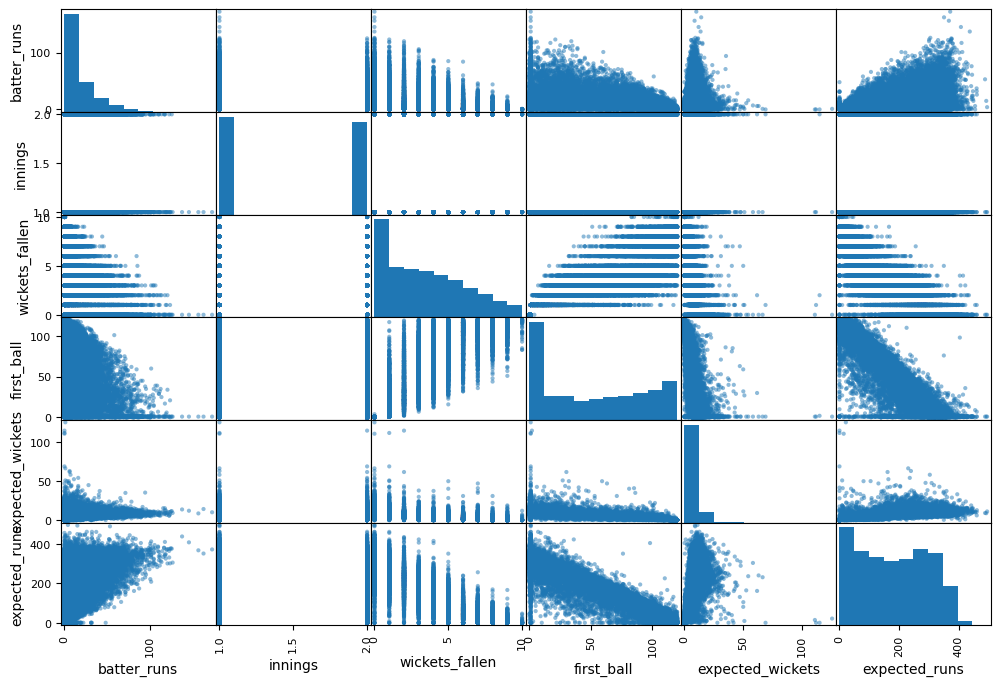

In [71]:
from pandas.plotting import scatter_matrix
scatter_matrix(merged_df[['batter_runs', 'innings', 'wickets_fallen', 'first_ball', 'expected_wickets', 'expected_runs']], figsize=(12,8))

In [83]:
y = merged_df['batter_runs']
X = merged_df.drop(['batter','batter_runs', 'balls_faced', 'strike_rate', 'last_ball'] , axis=1)
X_processed = pd.get_dummies(data=X, dtype=int)
X_numeric = merged_df.drop(['batter', 'bowling_team'], axis = 1)

In [84]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


X_processed = pd.get_dummies(data=X, dtype=int)

forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, X_processed, y, scoring="neg_mean_squared_error", cv = 10)

display_scores(np.sqrt(-scores))

Scores:  [18.15748665 20.22829717 21.50885682 20.51717535 17.19304738 16.92365077
 17.33938388 17.22706243 18.06263532 13.66305967]
Mean:  18.082065543043996
Standard Deviation:  2.1266765540473234


In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 20],
              'min_child_weight': [4, 1],
              'silent': [1, 0],
              'subsample': [0.7, 0.2],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_processed, y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


/home/e19372/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:18:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/e19372/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/e19372/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:18:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/e19372/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/e19372/anaconda3/envs/myenv/

0.18279180597754996
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


Best Score = 0.18279180597754996
Best Parameter = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


parameters = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
model = XGBRegressor(**parameters)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

/home/e19372/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:04:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/e19372/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:04:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 17.49


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 17.81
